In [38]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import *

from PIL import Image
import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import trange
import tensorflow as tf

# Tạo tập Train, Test, Val

In [40]:

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.


    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

In [41]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

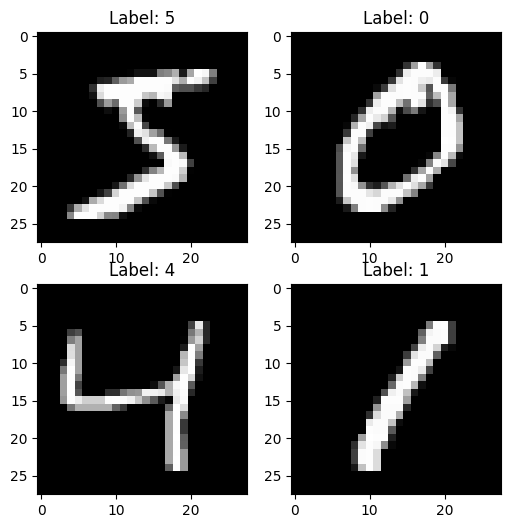

In [42]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray')

In [43]:
np.random.seed(42)

class Layer:
    def __init__(self):
        self.weights = np.zeros(shape=(input.shape[1], 10))
        self.bias = np.zeros(shape=(10,))
        pass
    
    def forward(self, input):
        output = np.matmul(input, self.weights) + self.bias
        return output
# Mỗi nơ-ron có một lớp được kết nối với mọi nơ-ron trong lớp ngay sau nó.
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.01):
        self.learning_rate = learning_rate
        
        # khỏi tạo weights và biases ngẫu nhiên
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
    
    # lan truyền tiến
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
    # lan truyền ngược
    def backward(self,input,grad_output):

        grad_input = np.dot(grad_output,np.transpose(self.weights))

        # tính lại cac sweight và biases
        grad_weights = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_biases = np.sum(grad_output, axis = 0)
        
        # cập nhật lại weight và biases
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):

        return np.maximum(0,input)

    def backward(self, input, grad_output):

        relu_grad = input > 0
        return grad_output*relu_grad 
    
class Sigmoid(Layer):
    def __init__(self):

        pass
    
    def forward(self,input):
        sig = 1 / (1 + np.exp(-input))
        return sig


    def backward(self,input,grad_output):
        d_sig = 1 / (1 + np.exp(-input)) * (1 - 1 / (1 + np.exp(-input)))
        return d_sig*grad_output

def softmax_crossentropy_with_logits(y_hat_logits,y):

    y_hat_logits_for_answers = y_hat_logits[np.arange(len(y_hat_logits)),y]
    
    xentropy = - y_hat_logits_for_answers + np.log(np.sum(np.exp(y_hat_logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(y_hat_logits,y):

    ones_for_answers = np.zeros_like(y_hat_logits)
    ones_for_answers[np.arange(len(y_hat_logits)),y] = 1
    
    softmax = np.exp(y_hat_logits) / np.exp(y_hat_logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / y_hat_logits.shape[0]

def softmax_stable(Z):
    
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    
    return A

def d_sigmoid(z):
    sf=softmax_stable(z)
    d_sig = sf * (1 - sf)
    return d_sig

def cost(Y, Yhat):
    return -np.sum(Y*np.log(Yhat))/Y.shape[1]

network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))


def forward(network, X):
    """
    Tính hàm kích hoạt của tất cả các lớp bằng cách áp dụng chúng một cách tuần tự.
    Trả về danh sách kích hoạt cho mỗi lớp.
    """
    activations = []
    input = X
    for i in range(len(network)):
        activations.append(network[i].forward(X))
        X = network[i].forward(X)
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Dự đoán đầu ra
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)


def train(network,X,y):
    
    # Dự đoán Xtrain[i] => đưa ra layer_activations
    layer_activations = forward(network,X)
    # Lấy dự đoán cuối cùng
    y_hat_logits = layer_activations[-1]
    
    # tính toán loss
    loss = softmax_crossentropy_with_logits(y_hat_logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(y_hat_logits,y)
    for i in range(1, len(network)):
        loss_grad = network[len(network) - i].backward(layer_activations[len(network) - i - 1], loss_grad)
    
    return np.mean(loss)
    # return np.max(loss)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        

In [52]:
layer_activations = forward(network,X_train[:32])
    # Lấy dự đoán cuối cùng
y_hat_logits = layer_activations[-1]
y_hat_logits.shape

(32, 10)

In [54]:
loss = softmax_crossentropy_with_logits(y_hat_logits,y_train[:32])
loss.shape

(32,)

In [59]:
np.arange(len(y_hat_logits))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [60]:
y_train[:32]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8], dtype=uint8)

In [61]:
y_hat_logits[0,5]

2.396569304607409

In [63]:
y_hat_logits_for_answers = y_hat_logits[np.arange(len(y_hat_logits)),y_train[:32]]
y_hat_logits_for_answers

array([ 2.3965693 , 11.07990928,  5.27263229,  6.34118743,  7.7425038 ,
        6.77665263,  8.3077612 ,  6.93941868,  6.63593409,  7.17755291,
        8.64023607,  2.81362524, 10.61559728,  5.73175693,  6.79051486,
        8.66963995,  7.10453983,  5.27469868,  2.85050188,  3.05299601,
        5.20159331, 11.91438858,  1.58217118,  6.3737818 , -1.24976528,
        7.62384409,  5.76619178, 11.21327698,  5.42135475,  2.90809892,
        4.49789598,  6.70898869])

In [64]:
xentropy = - y_hat_logits_for_answers + np.log(np.sum(np.exp(y_hat_logits),axis=-1))
xentropy

array([1.61385103e+00, 1.71921207e-03, 1.89263823e-01, 5.84862346e-02,
       2.68265023e-02, 4.40476581e-02, 4.12561267e-03, 9.74732064e-02,
       1.75601905e-02, 1.37577928e-02, 4.83074960e-03, 1.11289456e+00,
       1.76829029e-03, 6.25394990e-02, 1.47326988e-02, 1.43729557e-01,
       2.92148377e-02, 1.00054529e-01, 9.11412407e-01, 7.55393744e-01,
       6.59244620e-01, 4.55145777e-04, 2.17636608e+00, 3.03334332e-02,
       4.18562197e+00, 6.79766960e-01, 3.27106052e-01, 1.03014689e-03,
       1.32562696e+00, 9.72613456e-01, 1.07239658e-01, 8.95800662e-02])

In [ ]:
train_log = []
val_log = []
train_loss=[]
val_loss=[]
epochs=100
for epoch in range(epochs):
    tloss=[]
    vloss=[]
    print(f"epoch: {epoch+1}/{epochs}")
    
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train_lf=train(network,x_batch,y_batch)
        tloss.append(train_lf)
        
    for x_batch,y_batch in iterate_minibatches(X_val,y_val,batchsize=32,shuffle=True):
        val_lf=train(network,x_batch,y_batch)
        vloss.append(val_lf)
        
    train_loss.append(sum(tloss)/len(tloss))
    print(f"Train Loss: {train_loss[-1]}")
    val_loss.append(sum(vloss)/len(vloss))
    print(f"Val Loss: {val_loss[-1]}")
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    print(f"Train Accuracy: {train_log[-1]}")
    val_log.append(np.mean(predict(network,X_val)==y_val))
    print(f"Val Accuracy: {val_log[-1]}")

Epoch 100
Train accuracy: 0.86946
Val accuracy: 0.8873


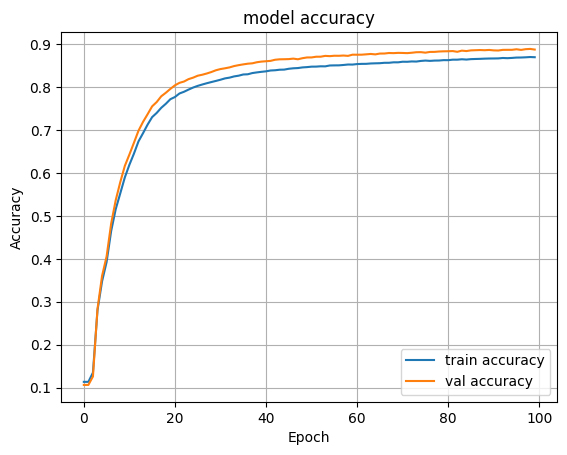

In [45]:
print("Epoch",epoch+1)
print("Train accuracy:",train_log[-1])
print("Val accuracy:", val_log[-1])
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.title("model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid()
plt.show()

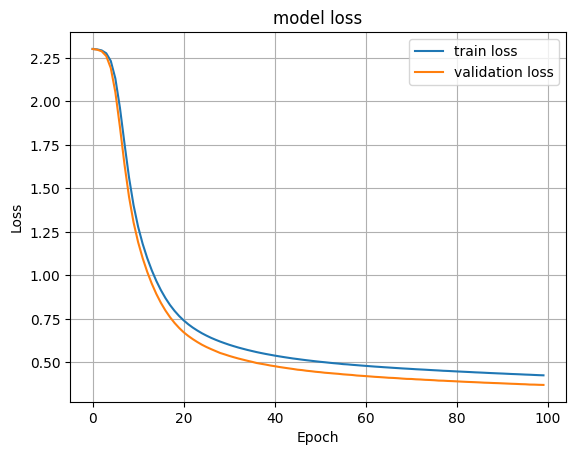

In [46]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='best')
plt.title("model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

87.76 %


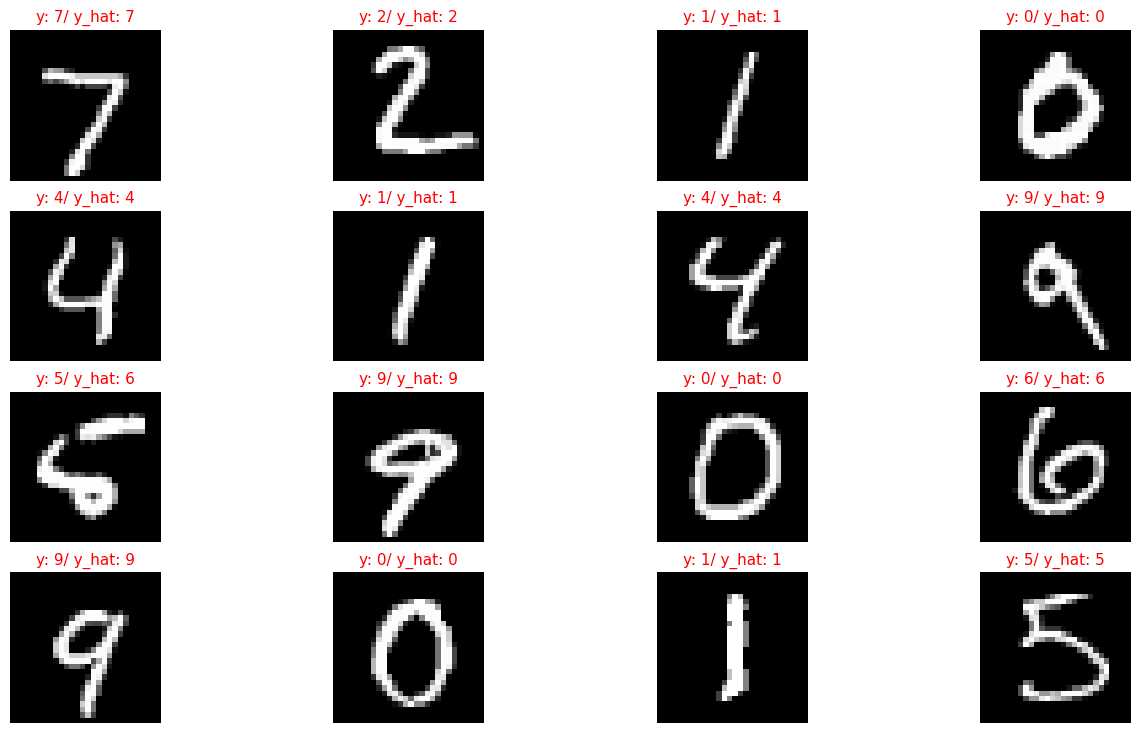

In [50]:
lb_pre=predict(network,X_test)
print(len(y_test[lb_pre==y_test])/len(y_test) *100,"%")
fig=plt.figure(figsize=[16,9])
for i in range(16):
    ax=fig.add_subplot(4,4,i+1)
    ax.imshow(X_test[i].reshape([28,28]),cmap='gray')
    # plt.title(f"Label:{tenLb[lb_pre[i]]}")
    ax.set_title('y: {y}/ y_hat: {y_hat}'.format(y=y_test[i], y_hat=lb_pre[i]),fontsize=11,color='red')
    plt.axis('off')